### PyTorch Practice - MNIST

Writing a pytorch code to classify handwritten images from the MNIST dataset.

Source for the dataset - [https://www.kaggle.com/datasets/hojjatk/mnist-dataset/data]

In [3]:
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

In [4]:
%%time
# Load MNIST IDX files and split into train, validation, and test sets

def load_idx_images(path):
    with open(path,'rb') as f:
        data = np.frombuffer(f.read(), dtype=np.uint8)
    return data[16:].reshape(-1, 28*28) / 255.0

def load_idx_labels(path):
    with open(path,'rb') as f:
        data = np.frombuffer(f.read(), dtype=np.uint8)
    return data[8:]

# Load full training set
X_full = load_idx_images('../../Downloads/archive/train-images.idx3-ubyte')
y_full = load_idx_labels('../../Downloads/archive/train-labels.idx1-ubyte')
# Load test set
X_test = load_idx_images('../../Downloads/archive/t10k-images.idx3-ubyte')
y_test = load_idx_labels('../../Downloads/archive/t10k-labels.idx1-ubyte')
# Split off validation set from training data
X_train, X_val, y_train, y_val = train_test_split(X_full, y_full, test_size=10000, random_state=42)

CPU times: user 64.9 ms, sys: 71.8 ms, total: 137 ms
Wall time: 134 ms


In [5]:
X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape

((50000, 784), (10000, 784), (10000, 784), (50000,), (10000,), (10000,))

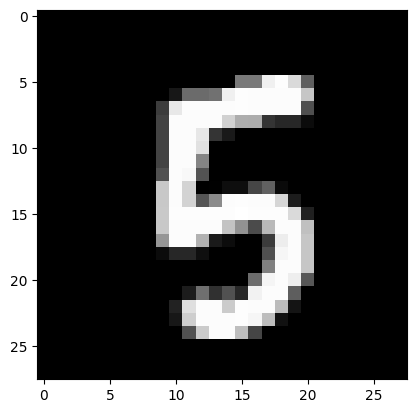

In [6]:
plt.imshow(X_train[1].reshape((28,28)), cmap='gray')

In [7]:
import torch
from torch import nn

In [8]:
device = torch.device("cpu")  # Fallback to CPU

In [10]:
X_train = torch.tensor(X_train).type(torch.float)
y_train = torch.tensor(y_train).type(torch.LongTensor)
X_val = torch.tensor(X_val).type(torch.float)
y_val = torch.tensor(y_val).type(torch.LongTensor)
X_test = torch.tensor(X_test).type(torch.float)
y_test = torch.tensor(y_test).type(torch.LongTensor)

In [11]:
# Put data to target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_val, y_val = X_val.to(device), y_val.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

In [21]:
class mnist_classify(nn.Module):
    def __init__(self, model, X_train, y_train, X_test, y_test, loss_fn=None, optimizer=None):
        super().__init__()
        self.model = model
        self.X_train = X_train
        self.y_train = y_train
        self.X_test = X_test
        self.y_test = y_test
        if loss_fn:
            self.loss_fn = loss_fn
        else:
            self.loss_fn = nn.CrossEntropyLoss()
        if optimizer:
            self.optimizer = optimizer
        else:
            self.optimizer = torch.optim.SGD(params=self.model.parameters(), lr = 0.1)

    def convert_ohe(self):
        self.y_train_ohe = nn.functional.one_hot(self.y_train, num_classes=10).float()
        self.y_test_ohe = nn.functional.one_hot(self.y_test, num_classes=10).float()

    # Calculate accuracy (a classification metric)
    def accuracy_fn(self,y_true, y_pred):
        correct = torch.eq(y_true, y_pred).sum().item() # torch.eq() calculates where two tensors are equal
        acc = (correct / len(y_pred)) * 100 
        return acc
    
    def training_loop(self, epochs=100, seed=42):
        # setting seed for reproducibility
        torch.manual_seed(seed)
        
        # Build training and evaluation loop
        for epoch in range(epochs):
            ### Training - several operations like batch norm and drop out are stopped using inference mode 
            ## and is only used while training mode is why model.train is used
            self.model.train()
        
            # 1. Forward pass (model outputs raw logits)
            y_logits = self.model(self.X_train).squeeze() # squeeze to remove extra `1` dimensions, this won't work unless model and data are on same device 
            y_pred = nn.functional.softmax(y_logits) # turn logits -> pred probs -> pred labls
          
            loss = self.loss_fn(y_logits, 
                           self.y_train_ohe) 
            self.y_pred = torch.tensor(np.argmax(torch.detach(y_pred).numpy(),axis=1)).type(torch.float)
            acc = self.accuracy_fn(y_true=self.y_train, 
                              y_pred=self.y_pred) 
        
            # 3. Optimizer zero grad
            self.optimizer.zero_grad()
        
            # 4. Loss backwards
            loss.backward()
        
            # 5. Optimizer step
            self.optimizer.step()
        
            ### Testing
            model_0.eval()
            with torch.inference_mode():
                # 1. Forward pass
                test_logits = self.model(self.X_test).squeeze() 
                test_pred = nn.functional.softmax(test_logits)
                # 2. Caculate loss/accuracy
                test_loss = self.loss_fn(test_logits,
                                    self.y_test_ohe)
                self.test_pred = torch.tensor(np.argmax(torch.detach(test_pred).numpy(),axis=1)).type(torch.float)
                test_acc = self.accuracy_fn(y_true=self.y_test,
                                       y_pred=self.test_pred)
        
            # Print out what's happening every 10 epochs
            if epoch % 20 == 0:
                print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")

    def predict_from_model(self, X_adhoc):
        logits = self.model(X_adhoc).squeeze()
        adhoc_pred = nn.functional.softmax(logits)
        adhoc_pred = torch.tensor(np.argmax(torch.detach(adhoc_pred).numpy(),axis=1)).type(torch.float)
        return adhoc_pred

## Experiments

In [22]:
model_0 = nn.Sequential(
    nn.Linear(in_features=784, out_features=512),
    nn.ReLU(),
    nn.Linear(in_features=512, out_features=10)
).to(device)
model_0

Sequential(
  (0): Linear(in_features=784, out_features=512, bias=True)
  (1): ReLU()
  (2): Linear(in_features=512, out_features=10, bias=True)
)

In [23]:
%%time

model_0_obj = mnist_classify(model_0, X_train, y_train, X_val, y_val)
model_0_obj.convert_ohe()
model_0_obj.training_loop()

Epoch: 0 | Loss: 2.31229, Accuracy: 7.80% | Test loss: 2.28802, Test acc: 12.40%
Epoch: 20 | Loss: 1.75823, Accuracy: 73.85% | Test loss: 1.72620, Test acc: 73.93%
Epoch: 40 | Loss: 1.12544, Accuracy: 80.33% | Test loss: 1.10653, Test acc: 80.11%
Epoch: 60 | Loss: 0.80228, Accuracy: 83.84% | Test loss: 0.79519, Test acc: 83.69%
Epoch: 80 | Loss: 0.64891, Accuracy: 85.53% | Test loss: 0.64561, Test acc: 85.38%
CPU times: user 13 s, sys: 4.83 s, total: 17.8 s
Wall time: 5.84 s


In [24]:
model_1 = nn.Sequential(
    nn.Linear(in_features=784, out_features=512),
    nn.ReLU(),
    nn.Linear(in_features=512, out_features=10)
).to(device)
model_1

Sequential(
  (0): Linear(in_features=784, out_features=512, bias=True)
  (1): ReLU()
  (2): Linear(in_features=512, out_features=10, bias=True)
)

In [25]:
%%time

model_1_obj = mnist_classify(model_1, X_train, y_train, X_val, y_val)
model_1_obj.convert_ohe()
model_1_obj.training_loop(epochs=300)

Epoch: 0 | Loss: 2.31229, Accuracy: 7.80% | Test loss: 2.28802, Test acc: 12.40%
Epoch: 20 | Loss: 1.75823, Accuracy: 73.85% | Test loss: 1.72620, Test acc: 73.93%
Epoch: 40 | Loss: 1.12544, Accuracy: 80.33% | Test loss: 1.10653, Test acc: 80.11%
Epoch: 60 | Loss: 0.80228, Accuracy: 83.84% | Test loss: 0.79519, Test acc: 83.69%
Epoch: 80 | Loss: 0.64891, Accuracy: 85.53% | Test loss: 0.64561, Test acc: 85.38%
Epoch: 100 | Loss: 0.56283, Accuracy: 86.65% | Test loss: 0.56056, Test acc: 86.52%
Epoch: 120 | Loss: 0.50817, Accuracy: 87.40% | Test loss: 0.50598, Test acc: 87.16%
Epoch: 140 | Loss: 0.47050, Accuracy: 88.05% | Test loss: 0.46807, Test acc: 87.87%
Epoch: 160 | Loss: 0.44296, Accuracy: 88.51% | Test loss: 0.44022, Test acc: 88.33%
Epoch: 180 | Loss: 0.42190, Accuracy: 88.90% | Test loss: 0.41885, Test acc: 88.65%
Epoch: 200 | Loss: 0.40521, Accuracy: 89.24% | Test loss: 0.40190, Test acc: 88.93%
Epoch: 220 | Loss: 0.39157, Accuracy: 89.46% | Test loss: 0.38806, Test acc: 89.23%

In [26]:
model_2 = nn.Sequential(
    nn.Linear(in_features=784, out_features=512),
    nn.ReLU(),
    nn.Linear(in_features=512, out_features=256),
    nn.ReLU(),
    nn.Linear(in_features=256, out_features=10)
).to(device)
model_2

Sequential(
  (0): Linear(in_features=784, out_features=512, bias=True)
  (1): ReLU()
  (2): Linear(in_features=512, out_features=256, bias=True)
  (3): ReLU()
  (4): Linear(in_features=256, out_features=10, bias=True)
)

In [27]:
%%time

model_2_obj = mnist_classify(model_2, X_train, y_train, X_val, y_val)
model_2_obj.convert_ohe()
model_2_obj.training_loop(epochs=100)

Epoch: 0 | Loss: 2.30029, Accuracy: 10.30% | Test loss: 2.29581, Test acc: 10.85%
Epoch: 20 | Loss: 2.18350, Accuracy: 50.02% | Test loss: 2.17542, Test acc: 51.26%
Epoch: 40 | Loss: 1.88301, Accuracy: 69.01% | Test loss: 1.86091, Test acc: 69.70%
Epoch: 60 | Loss: 1.27719, Accuracy: 75.61% | Test loss: 1.25246, Test acc: 75.66%
Epoch: 80 | Loss: 0.85422, Accuracy: 80.77% | Test loss: 0.84494, Test acc: 80.51%
CPU times: user 18.3 s, sys: 7.3 s, total: 25.6 s
Wall time: 8.34 s


In [28]:
model_3 = nn.Sequential(
    nn.Linear(in_features=784, out_features=512),
    nn.ReLU(),
    nn.Linear(in_features=512, out_features=256),
    nn.ReLU(),
    nn.Linear(in_features=256, out_features=10)
).to(device)
model_3

Sequential(
  (0): Linear(in_features=784, out_features=512, bias=True)
  (1): ReLU()
  (2): Linear(in_features=512, out_features=256, bias=True)
  (3): ReLU()
  (4): Linear(in_features=256, out_features=10, bias=True)
)

In [30]:
%%time

model_3_obj = mnist_classify(model_3, X_train, y_train, X_val, y_val)
model_3_obj.convert_ohe()
model_3_obj.training_loop(epochs=400)

Epoch: 0 | Loss: 0.33900, Accuracy: 90.38% | Test loss: 0.33601, Test acc: 90.40%
Epoch: 20 | Loss: 0.33095, Accuracy: 90.58% | Test loss: 0.32802, Test acc: 90.66%
Epoch: 40 | Loss: 0.32368, Accuracy: 90.75% | Test loss: 0.32086, Test acc: 90.84%
Epoch: 60 | Loss: 0.31703, Accuracy: 90.92% | Test loss: 0.31437, Test acc: 90.97%
Epoch: 80 | Loss: 0.31089, Accuracy: 91.07% | Test loss: 0.30840, Test acc: 91.14%
Epoch: 100 | Loss: 0.30515, Accuracy: 91.25% | Test loss: 0.30288, Test acc: 91.28%
Epoch: 120 | Loss: 0.29977, Accuracy: 91.38% | Test loss: 0.29773, Test acc: 91.39%
Epoch: 140 | Loss: 0.29467, Accuracy: 91.55% | Test loss: 0.29288, Test acc: 91.56%
Epoch: 160 | Loss: 0.28983, Accuracy: 91.75% | Test loss: 0.28831, Test acc: 91.74%
Epoch: 180 | Loss: 0.28520, Accuracy: 91.88% | Test loss: 0.28397, Test acc: 91.83%
Epoch: 200 | Loss: 0.28076, Accuracy: 92.01% | Test loss: 0.27983, Test acc: 91.94%
Epoch: 220 | Loss: 0.27649, Accuracy: 92.14% | Test loss: 0.27585, Test acc: 91.99

In [31]:
model_4 = nn.Sequential(
    nn.Linear(in_features=784, out_features=512),
    nn.ReLU(),
    nn.Linear(in_features=512, out_features=10)
).to(device)
model_4

Sequential(
  (0): Linear(in_features=784, out_features=512, bias=True)
  (1): ReLU()
  (2): Linear(in_features=512, out_features=10, bias=True)
)

In [32]:
%%time

model_4_obj = mnist_classify(model_4, X_train, y_train, X_val, y_val)
model_4_obj.convert_ohe()
model_4_obj.training_loop(epochs=1000)

Epoch: 0 | Loss: 2.31229, Accuracy: 7.80% | Test loss: 2.28802, Test acc: 12.40%
Epoch: 20 | Loss: 1.75823, Accuracy: 73.85% | Test loss: 1.72620, Test acc: 73.93%
Epoch: 40 | Loss: 1.12544, Accuracy: 80.33% | Test loss: 1.10653, Test acc: 80.11%
Epoch: 60 | Loss: 0.80228, Accuracy: 83.84% | Test loss: 0.79519, Test acc: 83.69%
Epoch: 80 | Loss: 0.64891, Accuracy: 85.53% | Test loss: 0.64561, Test acc: 85.38%
Epoch: 100 | Loss: 0.56283, Accuracy: 86.65% | Test loss: 0.56056, Test acc: 86.52%
Epoch: 120 | Loss: 0.50817, Accuracy: 87.40% | Test loss: 0.50598, Test acc: 87.16%
Epoch: 140 | Loss: 0.47050, Accuracy: 88.05% | Test loss: 0.46807, Test acc: 87.87%
Epoch: 160 | Loss: 0.44296, Accuracy: 88.51% | Test loss: 0.44022, Test acc: 88.33%
Epoch: 180 | Loss: 0.42190, Accuracy: 88.90% | Test loss: 0.41885, Test acc: 88.65%
Epoch: 200 | Loss: 0.40521, Accuracy: 89.24% | Test loss: 0.40190, Test acc: 88.93%
Epoch: 220 | Loss: 0.39157, Accuracy: 89.46% | Test loss: 0.38806, Test acc: 89.23%

In [33]:
%%time

model_4_obj.training_loop(epochs=1000)

Epoch: 0 | Loss: 0.24025, Accuracy: 93.32% | Test loss: 0.24226, Test acc: 93.13%
Epoch: 20 | Loss: 0.23820, Accuracy: 93.39% | Test loss: 0.24039, Test acc: 93.20%
Epoch: 40 | Loss: 0.23618, Accuracy: 93.45% | Test loss: 0.23856, Test acc: 93.21%
Epoch: 60 | Loss: 0.23419, Accuracy: 93.51% | Test loss: 0.23675, Test acc: 93.25%
Epoch: 80 | Loss: 0.23222, Accuracy: 93.56% | Test loss: 0.23496, Test acc: 93.29%
Epoch: 100 | Loss: 0.23029, Accuracy: 93.62% | Test loss: 0.23320, Test acc: 93.33%
Epoch: 120 | Loss: 0.22838, Accuracy: 93.68% | Test loss: 0.23147, Test acc: 93.43%
Epoch: 140 | Loss: 0.22649, Accuracy: 93.74% | Test loss: 0.22976, Test acc: 93.47%
Epoch: 160 | Loss: 0.22463, Accuracy: 93.80% | Test loss: 0.22807, Test acc: 93.57%
Epoch: 180 | Loss: 0.22279, Accuracy: 93.85% | Test loss: 0.22641, Test acc: 93.60%
Epoch: 200 | Loss: 0.22098, Accuracy: 93.90% | Test loss: 0.22478, Test acc: 93.68%
Epoch: 220 | Loss: 0.21918, Accuracy: 93.95% | Test loss: 0.22316, Test acc: 93.68

## Observation

Training a simple model for 2000 epochs has brought up the test accuracy to 95%. Let's use this to plot some images!

In [42]:
def plot_random_images(X, y, model_x_obj, pred=None):
    fig, ax = plt.subplots(5,5,figsize=(14,12))
    if pred is not None:
        y_pred = pred
    else:
        y_pred = model_x_obj.predict_from_model(X)
    for i in range(5):
        for j in range(5):
            idx = np.random.randint(low=0,high=len(X))
            x1 = X[idx].reshape((28,28))
            y1 = y[idx]
            ax[i][j].imshow(x1, cmap='gray')
            ax[i][j].set_title(f"Index : {idx},\nPredicted value : {y_pred[idx]}, \n actual value : {y1}")
    
    fig.tight_layout();

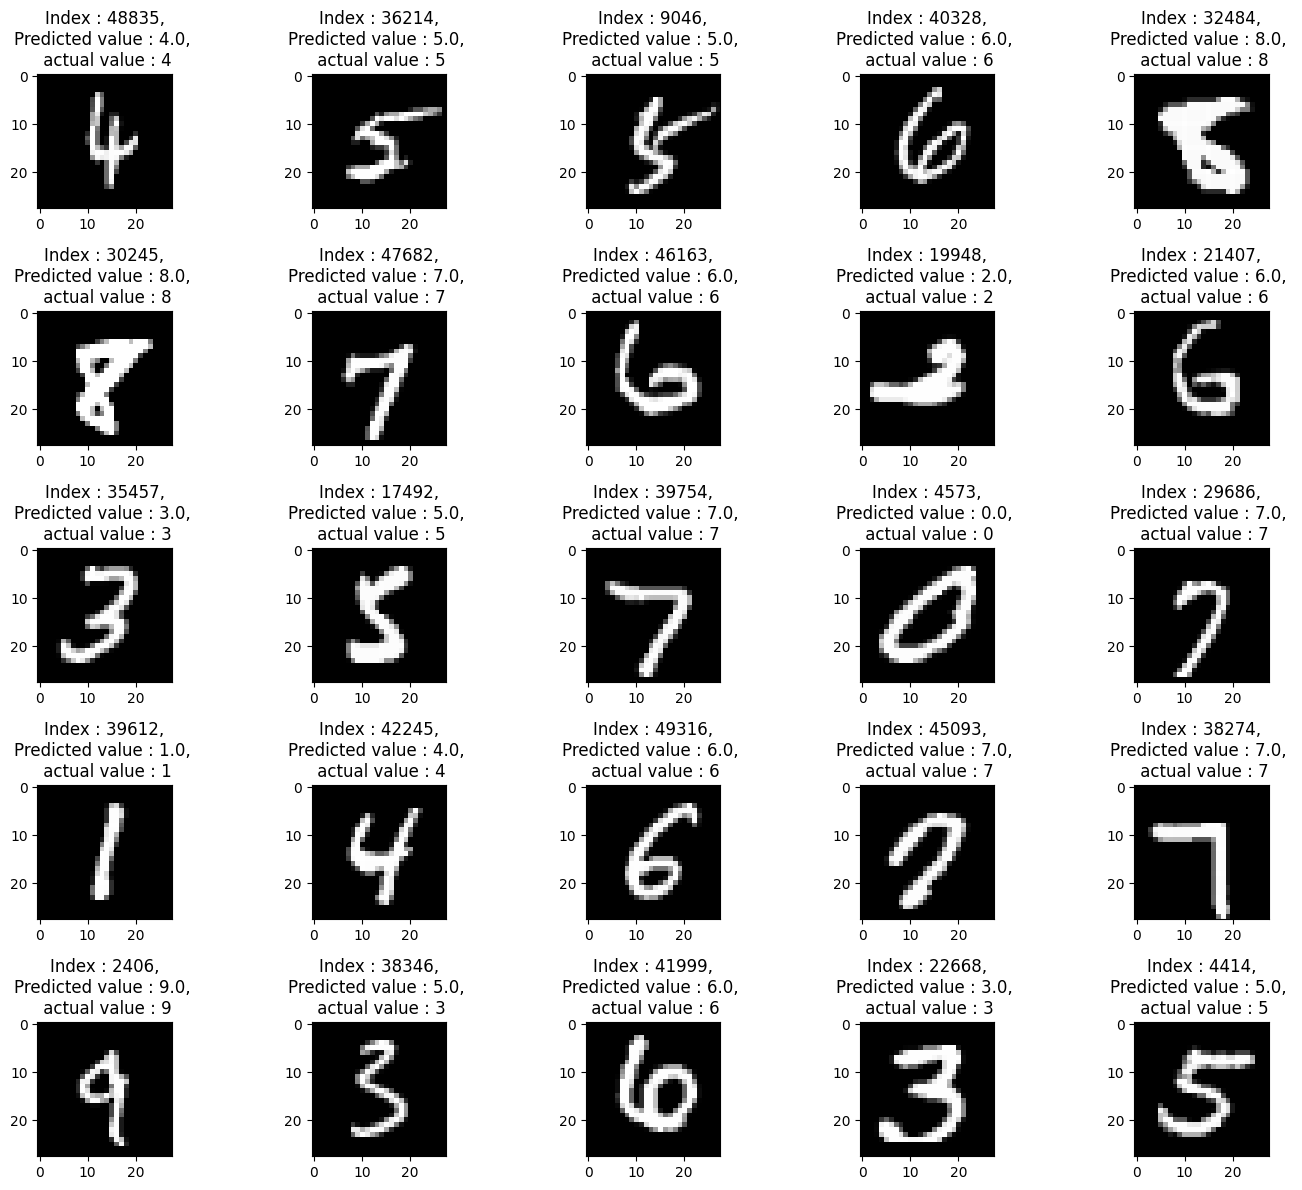

In [44]:
plot_random_images(X_train, y_train, model_4_obj, model_4_obj.y_pred)

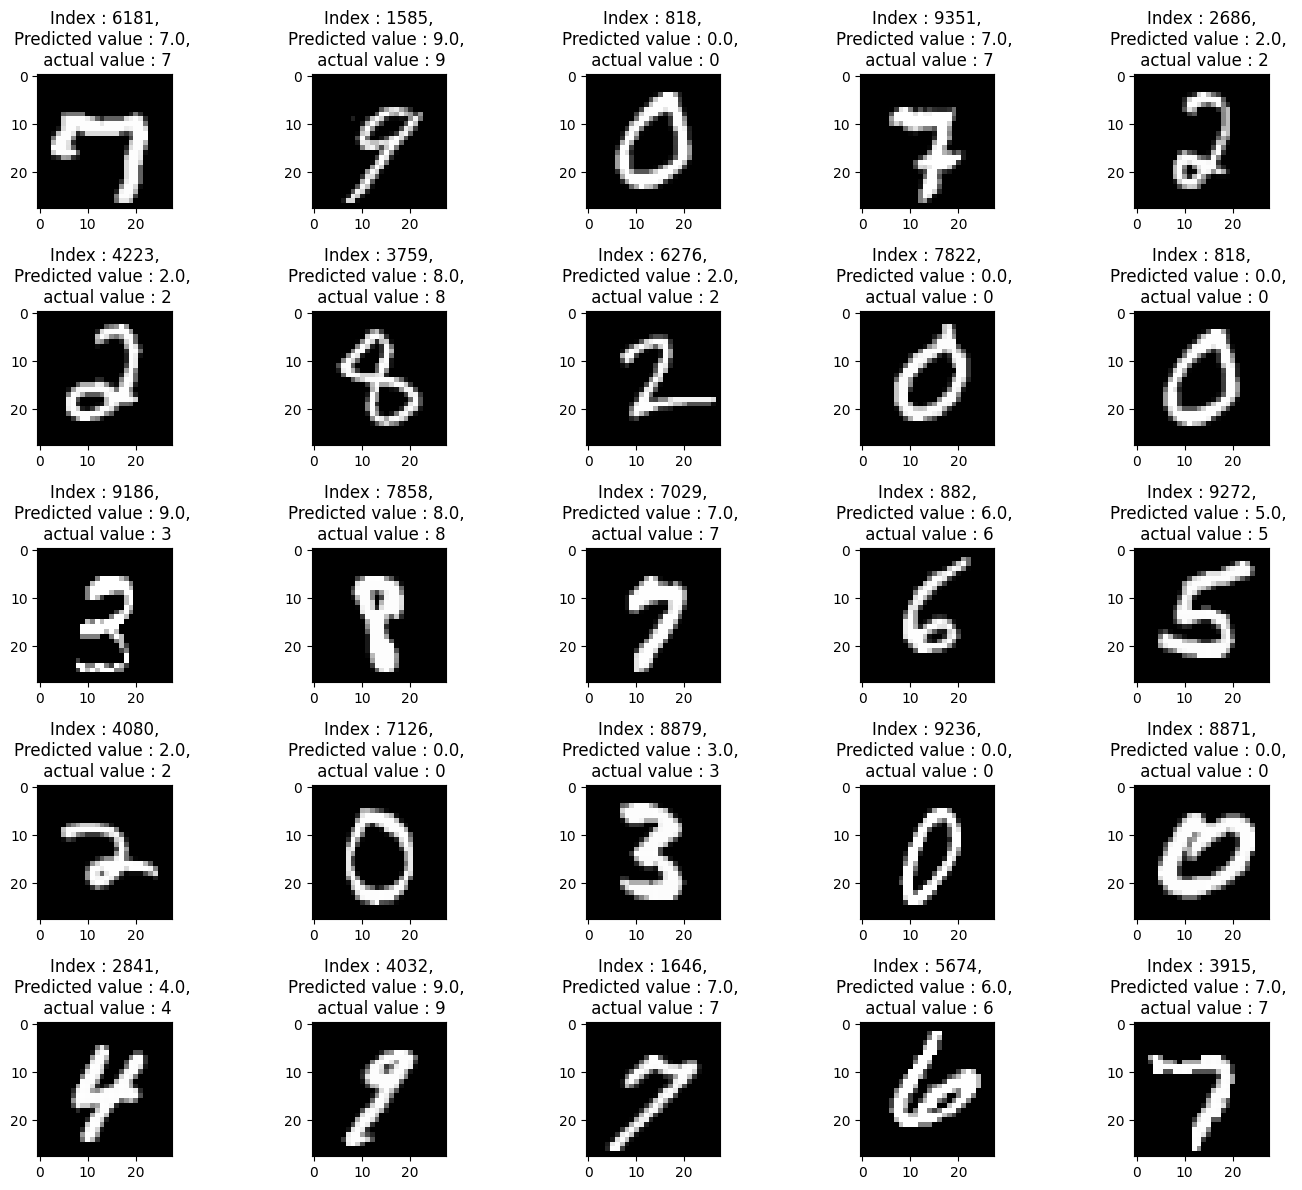

In [45]:
plot_random_images(X_val, y_val, model_4, model_4_obj.test_pred)

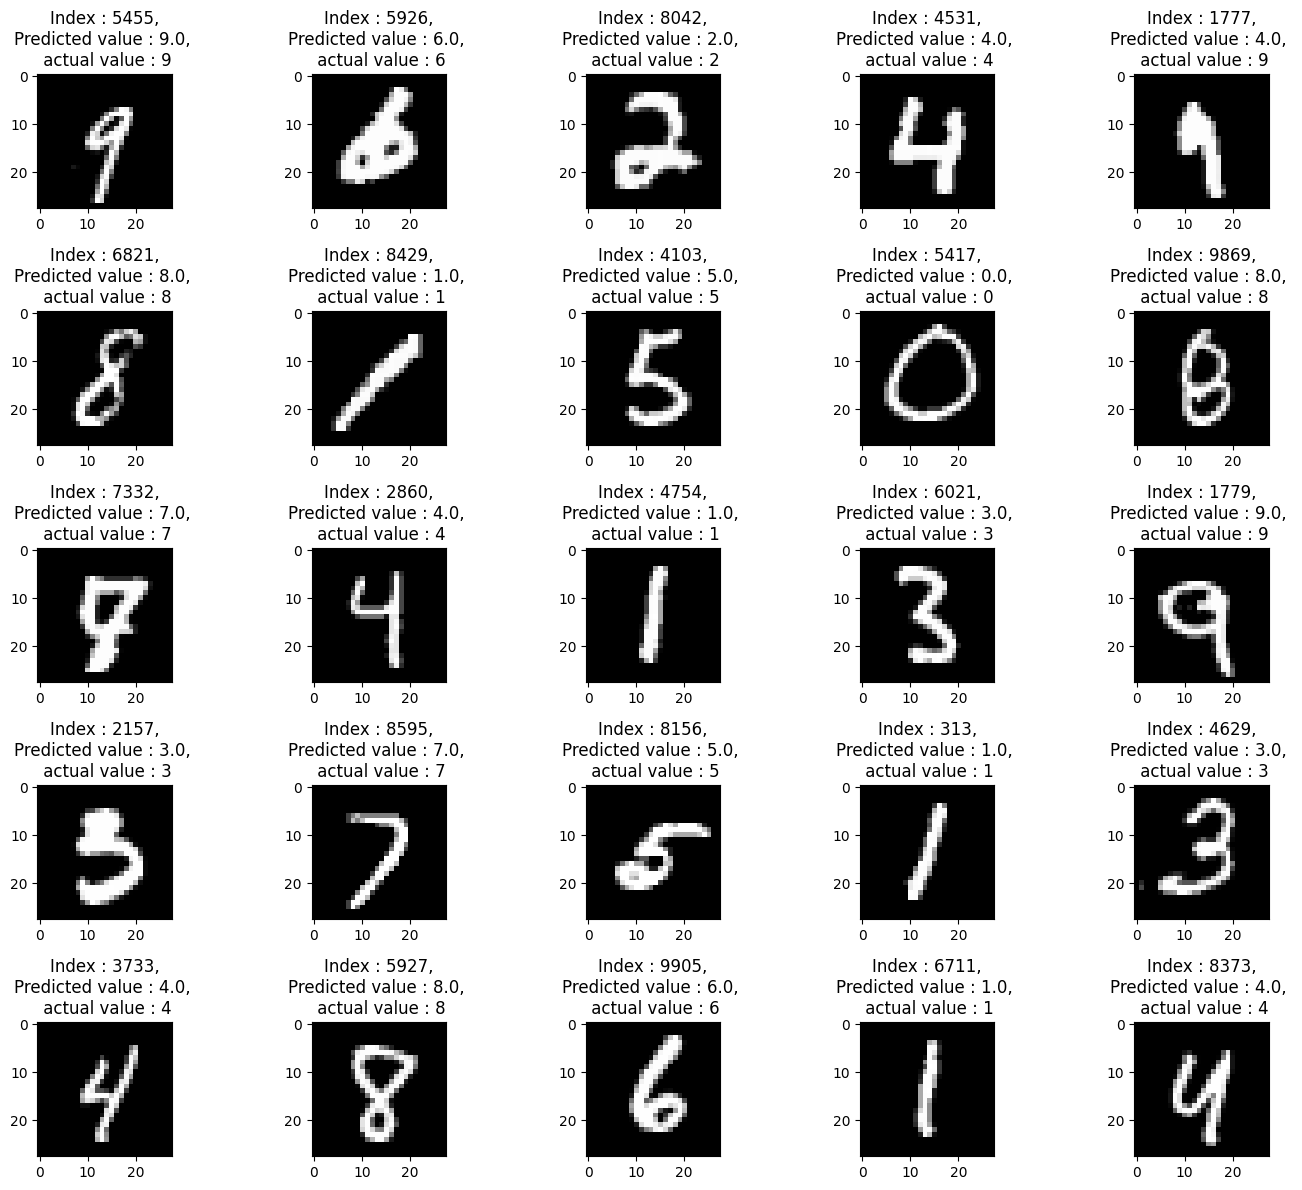

In [47]:
plot_random_images(X_val, y_val, model_4_obj)